In [1]:
%run sources/sequence_dataset.py
%run sources/sequence_walking_tree.py

SAMPLES = 140

from random import choice

In [2]:
def read_event_logs(csv_path):
    r = pd.read_csv(csv_path)
    return list(r["sequence"].apply(lambda x: eval(x) )), list(r["class"])

X,Y = read_event_logs("datasets/20240126_1832_fitbit_p02_events.csv")

In [3]:
DRIFT = 30
PREDICT = 10

Z = SequenceDataset()
Z.fit(X[SAMPLES - DRIFT:SAMPLES],Y[SAMPLES - DRIFT:SAMPLES])

Z.sample_df.loc[DRIFT - PREDICT:DRIFT,0 ] = 0


In [4]:
len(SequenceDataset.value_tests(Z.select_value({(i,0) for i in range(len(Z.raw_x))} )))

22

In [5]:
from math import log2
mh = int(log2(Z.last_position_df.last_position.mean()))
ms = int(log2(len(Z.raw_x)))
mh, ms

(4, 4)

In [6]:
C = SequenceWalkingTree(max_height=mh, min_node_samples=ms, alternate_if_possible=False, random_samples=None)
C = SequenceWalkingTree()
t = C.fit(Z)

/var/folders/q_/v4dkr4854lq5tz_bw1jfl0q80000gn/T/ipykernel_12955/1361663648.py:20: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pydot_graph = to_pydot(G)


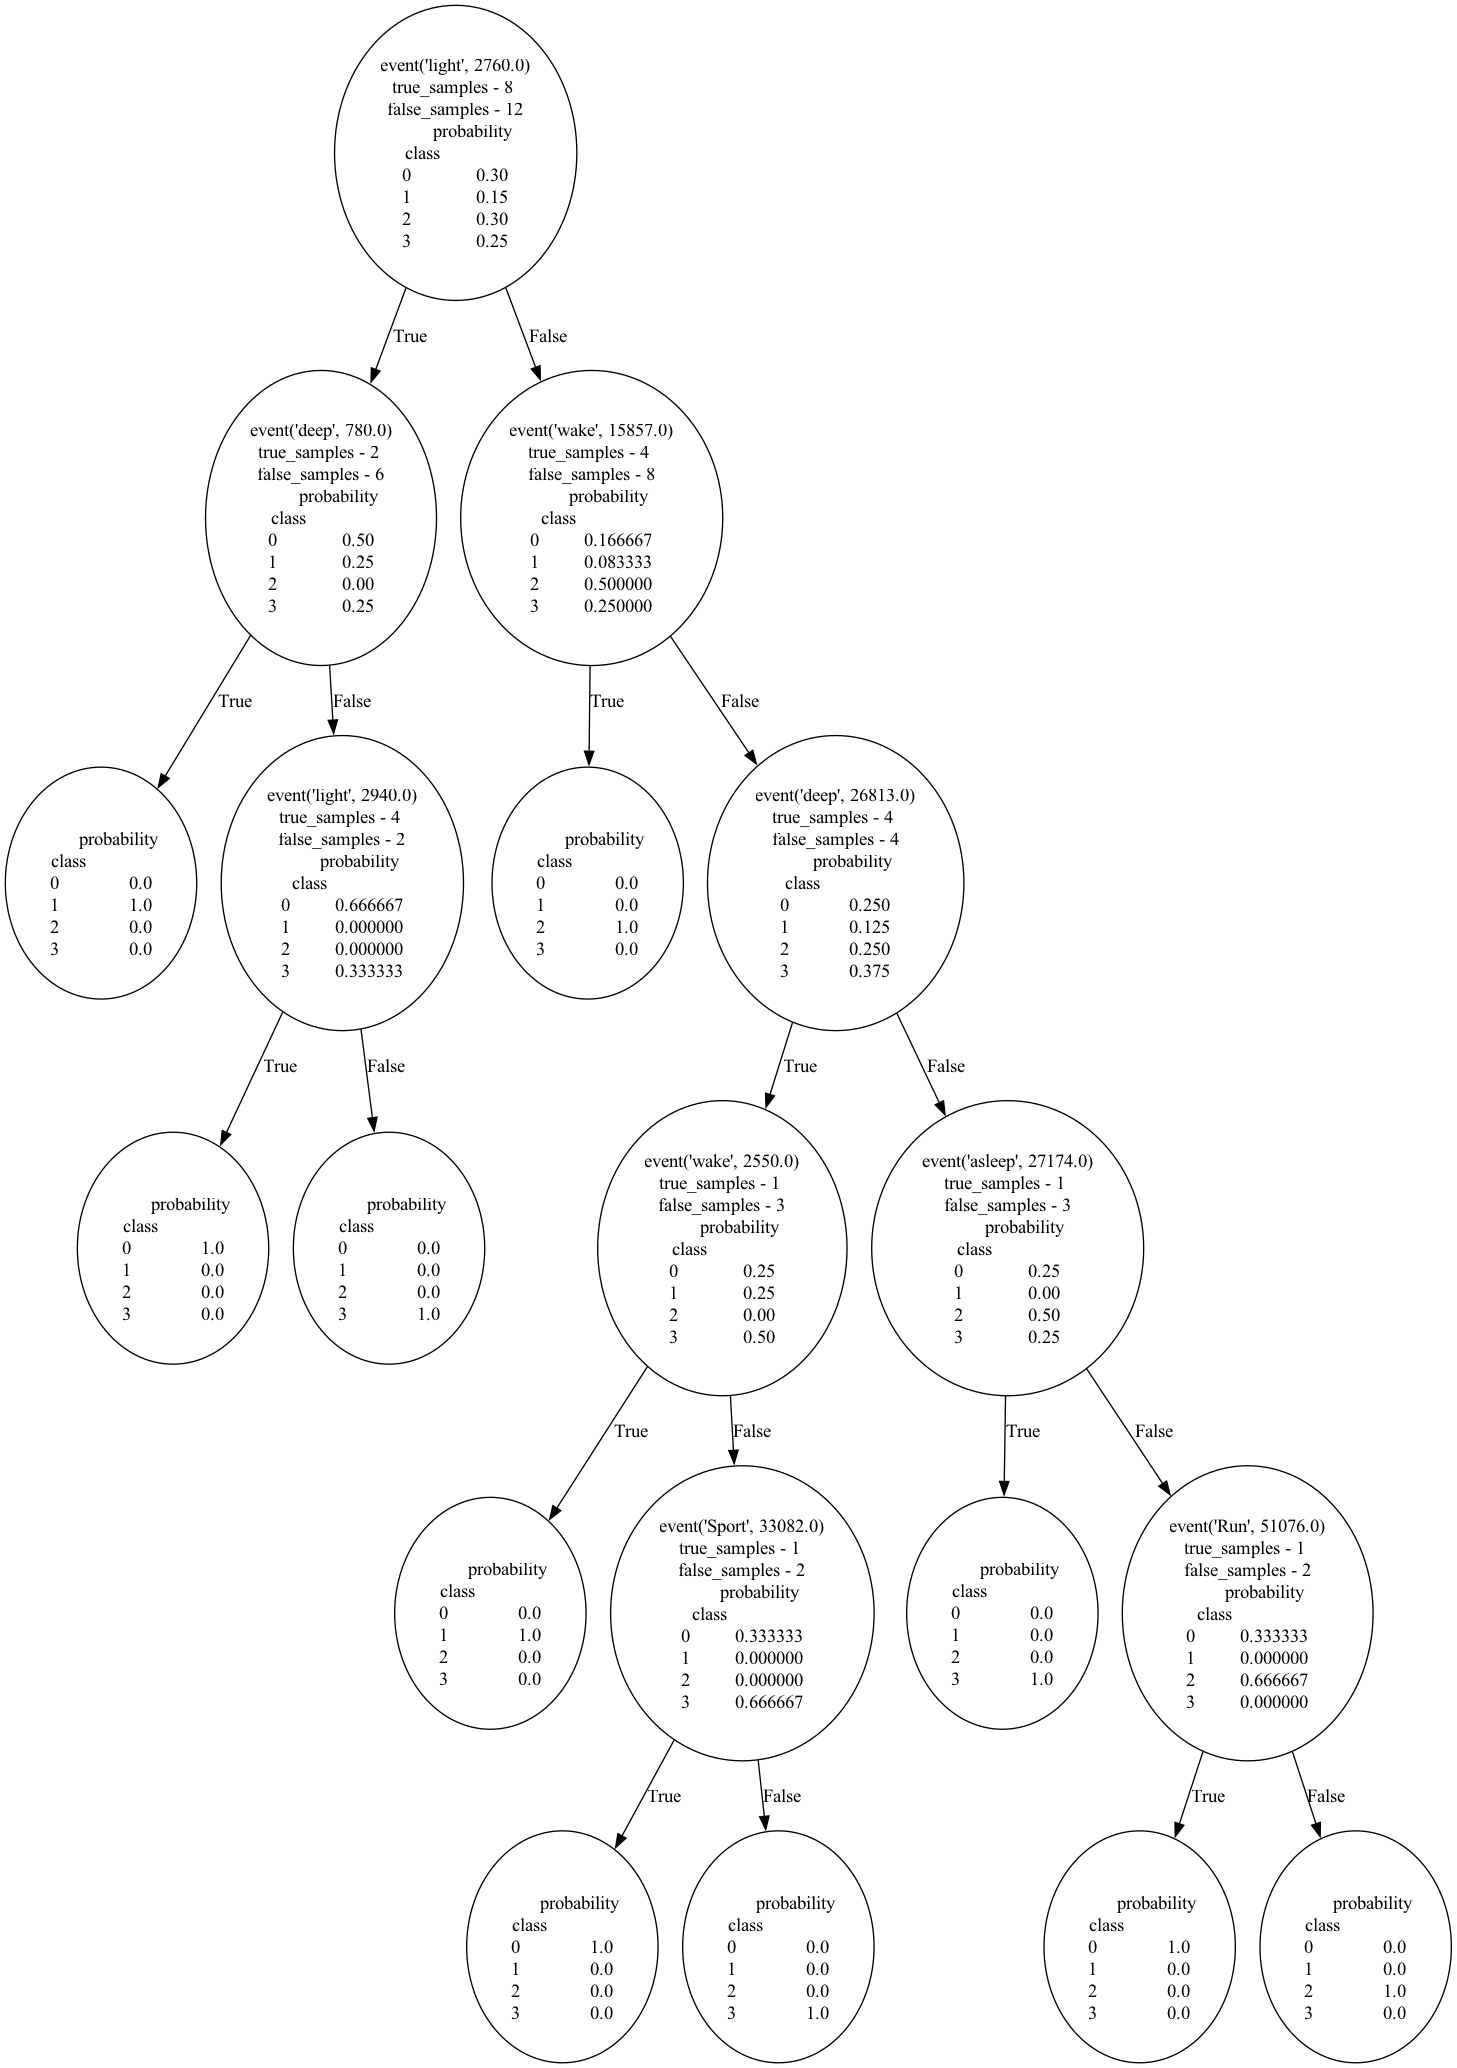

In [7]:
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
import networkx as nx


def generate_tree(g, t, k=0):
    newline = "\n"
    g.add_node(k, label=f'{t["test_type"] if "test_type" in t else ""}{t["test"] if "test" in t else ""}{newline + "true_samples - "+str(t["true_samples"])+ " " if "true_samples" in t else "" }{newline+"false_samples - "+str(t["false_samples"]) if "false_samples" in t else "" }{newline+str(t["probabilities"])}'  )
    next_k = k + 1
    for key in [True, False]:
        if key in t:
            current_k, next_k = generate_tree(g, t[key], next_k)
            g.add_edge(k, current_k, label= f'{key}')
    return k, next_k

G = nx.DiGraph()

generate_tree(G,C.tree)

pydot_graph = to_pydot(G)
dot_file_path = "tree.dot"
pydot_graph.write_dot(dot_file_path)

!dot -Tpng tree.dot -o tree.png

display(Image("tree.png"))

In [8]:
merged = pd.merge(Z.sample_df["class"], C.predict(Z, 0), left_index=True, right_index=True, how="inner")

In [9]:
merged

,class,prediction,path,nodes,positions,end_of_sequence
sample,,,,,,
20,2,2,"[False, True]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (16019.0, Walk, 3891000)), (0, (16019.0, ...",None
21,0,2,"[False, False, False, False, False]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (1665.0, Walk, 2918000)), (0, (1665.0, Wa...",None
22,0,3,"[False, False, False, True]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (31349.0, asleep, 4200)), (0, (31349.0, a...",None
23,2,3,"[True, False, False]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (42149.0, wake, 60)), (1, (42209.0, light...",None
24,2,0,"[True, False, True]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (32519.0, wake, 30)), (1, (32549.0, light...",None
25,1,1,"[True, True]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (30089.0, wake, 30)), (2, (31229.0, light...",None
26,2,3,"[False, False, True, False, False]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (29969.0, light, 1470)), (0, (29969.0, li...",None
27,1,0,"[True, False, True]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (30629.0, wake, 30)), (1, (30659.0, light...",None
28,0,0,"[True, False, True]","[{'test_type': 'event', 'test': ('light', 2760...","[(0, (25019.0, wake, 30)), (1, (25049.0, light...",None
